# Reading ADCP Data with MHKiT

The following example demonstrates a simple workflow for analyzing Acoustic Doppler Current Profiler (ADCP) data using MHKiT. MHKiT has brought the DOLfYN codebase in as an MHKiT module for working with ADCP and Acoustic Doppler Velocimeter (ADV) data. The DOLfYN MHKiT module is transferring functionality in two parts. In phase 1 the basic IO and core functions of DOLfYN are brought in. These functions include reading instrument data and rotating thru coordinate systems. In phase 2 DOLfYN analysis functions are brought in. As phase 2 is still in progress we will import the analysis tools from the [DOLfYN](https://github.com/lkilcher/dolfyn) package.

A typical ADCP data workflow is broken down into
  1. Review the raw data
      - Check timestamps
      - Calculate/check that the depth bin locations are correct
      - Look at velocity, beam amplitude and/or beam correlation data quality
  2. Remove data located above the water surface or below the seafloor
  3. Check for spurious datapoints and remove if necessary
  4. If not already done within the instrument, average the data into time bins of a set time length (normally 5 to 10 min)
  5. Conduct further analysis as required

Start by importing the necessary DOLfYN tools:

In [1]:
from mhkit import dolfyn as dlfn
from mhkit.dolfyn.adp import api

## Read Raw Instrument Data

The core benefit of DOLfYN is that it can read in raw data directly after transferring it off of the ADCP. The ADCP used here is a Nortek Signature1000, with the file extension '.ad2cp'. This specific dataset contains several hours worth of velocity data collected at 1 Hz from the ADCP mounted on a bottom lander in a tidal inlet. 
The instruments that DOLfYN supports are listed in the [docs](https://dolfyn.readthedocs.io/en/latest/about.html).

Start by reading in the raw datafile downloaded from the instrument. The `read` function reads the raw file and dumps the information into an xarray Dataset, which contains a few groups of variables:

1. Velocity in the instrument-saved coordinate system (beam, XYZ, ENU)
2. Beam amplitude and correlation data
3. Measurements of the instrument's bearing and environment
4. Orientation matrices DOLfYN uses for rotating through coordinate frames.


In [2]:
ds = dlfn.read('data/dolfyn/Sig1000_tidal.ad2cp')

Reading file data/dolfyn/Sig1000_tidal.ad2cp ...


There are two ways to see what's in a Dataset. The first is to simply type the dataset's name to see the standard xarray output. To access a particular variable in a dataset, use dict-style (`ds['vel']`) or attribute-style syntax (`ds.vel`). See the [xarray docs](http://xarray.pydata.org/en/stable/getting-started-guide/quick-overview.html) for more details on how to use the xarray format.

In [3]:
# print the dataset
ds

<xarray.Dataset>
Dimensions:              (time: 55000, time_b5: 55000, dirIMU: 3, range_b5: 28, beam: 4, range: 28, dir: 4, earth: 3, inst: 3, q: 4, x: 4, x*: 4)
Coordinates:
  * time                 (time) datetime64[ns] 2020-08-15T00:20:00.500999 ......
  * time_b5              (time_b5) datetime64[ns] 2020-08-15T00:20:00.438499 ...
  * dirIMU               (dirIMU) <U1 'E' 'N' 'U'
  * range_b5             (range_b5) float64 0.6 1.1 1.6 2.1 ... 13.1 13.6 14.1
  * beam                 (beam) int32 1 2 3 4
  * range                (range) float64 0.6 1.1 1.6 2.1 ... 12.6 13.1 13.6 14.1
  * dir                  (dir) <U2 'E' 'N' 'U1' 'U2'
  * earth                (earth) <U1 'E' 'N' 'U'
  * inst                 (inst) <U1 'X' 'Y' 'Z'
  * q                    (q) <U1 'w' 'x' 'y' 'z'
  * x                    (x) int32 1 2 3 4
  * x*                   (x*) int32 1 2 3 4
Data variables: (12/38)
    c_sound              (time) float32 1.502e+03 1.502e+03 ... 1.498e+03
    temp                 (time) float32 14.55 14.55 14.55 ... 13.47 13.47 13.47
    pressure             (time) float32 9.713 9.718 9.718 ... 9.596 9.594 9.596
    mag                  (dirIMU, time) float32 72.5 72.7 72.6 ... -197.2 -195.7
    accel                (dirIMU, time) float32 -0.00479 -0.01437 ... 9.729
    batt                 (time) float32 16.6 16.6 16.6 16.6 ... 16.4 16.4 15.2
    ...                   ...
    telemetry_data       (time) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    boost_running        (time) uint8 0 0 0 0 0 0 0 0 1 0 ... 0 1 0 0 0 0 0 0 1
    heading              (time) float32 -12.52 -12.51 -12.51 ... -12.52 -12.5
    pitch                (time) float32 -0.065 -0.06 -0.06 ... -0.06 -0.05 -0.05
    roll                 (time) float32 -7.425 -7.42 -7.42 ... -6.45 -6.45 -6.45
    beam2inst_orientmat  (x, x*) float32 1.183 0.0 -1.183 ... 0.5518 0.0 0.5518
Attributes: (12/33)
    filehead_config:       {'CLOCKSTR': {'TIME': '"2020-08-13 13:56:21"'}, 'I...
    inst_model:            Signature1000
    inst_make:             Nortek
    inst_type:             ADCP
    rotate_vars:           ['vel', 'accel', 'accel_b5', 'angrt', 'angrt_b5', ...
    burst_config:          {'press_valid': True, 'temp_valid': True, 'compass...
    ...                    ...
    proc_idle_less_3pct:   0
    proc_idle_less_6pct:   0
    proc_idle_less_12pct:  0
    coord_sys:             earth
    has_imu:               1
    fs:                    1

A second way provided to look at data is through the *DOLfYN view*. This view has several convenience methods, shortcuts, and functions built-in. It includes an alternate – and somewhat more informative/compact – description of the data object when in interactive mode. This can be accessed using

In [4]:
ds_dolfyn = ds.velds
ds_dolfyn

<ADCP data object>:  Nortek Signature1000
  . 15.28 hours (started: Aug 15, 2020 00:20)
  . earth-frame
  . (55000 pings @ 1Hz)
  Variables:
  - time ('time',)
  - time_b5 ('time_b5',)
  - vel ('dir', 'range', 'time')
  - vel_b5 ('range_b5', 'time_b5')
  - range ('range',)
  - orientmat ('earth', 'inst', 'time')
  - heading ('time',)
  - pitch ('time',)
  - roll ('time',)
  - temp ('time',)
  - pressure ('time',)
  - amp ('beam', 'range', 'time')
  - amp_b5 ('range_b5', 'time_b5')
  - corr ('beam', 'range', 'time')
  - corr_b5 ('range_b5', 'time_b5')
  - accel ('dirIMU', 'time')
  - angrt ('dirIMU', 'time')
  - mag ('dirIMU', 'time')
  ... and others (see `<obj>.variables`)

## First Steps and QC'ing Data

### 1.) Set deployment height

Because this is a Nortek instrument, the deployment software doesn't take into account the deployment height, aka where in the water column the ADCP is. The center of the first depth bin is located at a distance = deployment height + blanking distance + cell size, so the `range` coordinate needs to be corrected so that '0' corresponds to the seafloor. This can be done using the `set_range_offset` function. This same function can be used to account for the depth of a down-facing instrument below the water surface.

Note, if using a Teledyne RDI ADCP, TRDI's deployment software asks the user to enter the deployment height/depth during configuration. If needed, this can be adjusted after-the-fact using `set_range_offset` as well. 

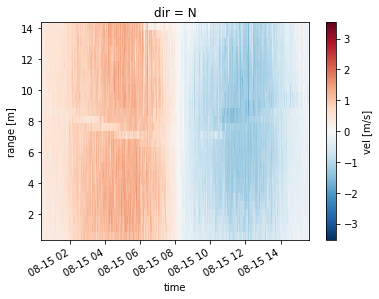

In [5]:
ds['vel'][1].plot()

In [6]:
# The ADCP transducers were measured to be 0.6 m from the feet of the lander
api.clean.set_range_offset(ds, 0.6)

So, the center of bin 1 is located at 1.2 m:

In [7]:
ds.range

<xarray.DataArray 'range' (range: 28)>
array([ 1.2,  1.7,  2.2,  2.7,  3.2,  3.7,  4.2,  4.7,  5.2,  5.7,  6.2,  6.7,
        7.2,  7.7,  8.2,  8.7,  9.2,  9.7, 10.2, 10.7, 11.2, 11.7, 12.2, 12.7,
       13.2, 13.7, 14.2, 14.7])
Coordinates:
  * range    (range) float64 1.2 1.7 2.2 2.7 3.2 ... 12.7 13.2 13.7 14.2 14.7
Attributes:
    units:    m

### 2.) Remove data beyond surface level

To reduce the amount of data the code must run through, we can remove all data at and above the water surface. Because the instrument was looking up, we can use the pressure sensor data and the function `find_surface_from_P`. This does require that the pressure sensor was 'zeroed' prior to deployment. If the instrument is looking down or lacks pressure data, use the function `find_surface` to detect the seabed or water surface.

ADCPs don't measure water salinity, so it will need to be given to the function. The returned dataset contains the an additional variable "depth". If `find_surface_from_P` is run after `set_range_offset`, depth is the distance of the water surface away from the seafloor; otherwise it is the distance to the ADCP pressure sensor.

After calculating depth, data in depth bins at and above the physical water surface can be removed using `nan_beyond_surface`. Note that this function returns a new dataset.

In [8]:
api.clean.find_surface_from_P(ds, salinity=31)
ds = api.clean.nan_beyond_surface(ds)

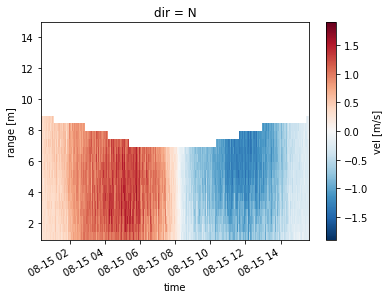

In [9]:
ds['vel'][1].plot()

### 3.) Correlation filter

Once beyond-surface bins have been removed, ADCP data is typically filtered by acoustic signal correlation to clear out spurious velocity datapoints (caused by bubbles, kelp, fish, etc moving through one or multiple beams).

We can take a quick look at the data to see about where this value should be using xarray's built-in plotting.
In the following line of code, we use xarray's slicing capabilities to show data from beam 1 between a range of 0 to 10 m from the ADCP.

Not all ADCPs return acoustic signal correlation, which in essence is a quantitative measure of signal quality. ADCPs with older hardware do not provide a correlation measurement, so this step will be skipped with these instruments.

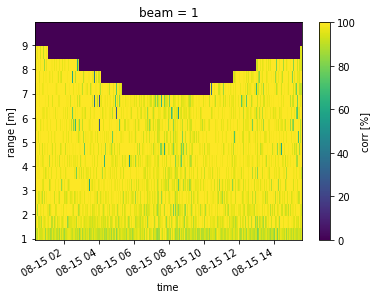

In [11]:
%matplotlib inline
ds.corr.sel(beam=1, range=slice(0,10)).plot()

It's a good idea to check the other beams as well. Much of this data is high quality, and to not lose data will low correlation caused by natural variation, we'll use the `correlation_filter` to set velocity values corresponding to correlations below 50% to NaN.

Note that this threshold is dependent on the deployment environment and instrument, and it isn't uncommon to use a value as low as 30%, or to pass on this function completely.

In [12]:
ds = api.clean.correlation_filter(ds, thresh=50)

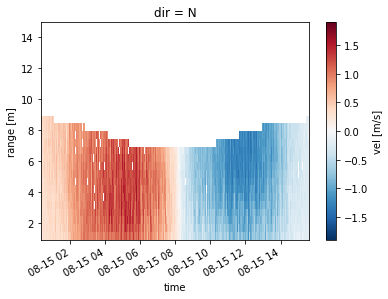

In [13]:
ds['vel'][1].plot()

## Rotate Data Coordinate System

Now that the data has been cleaned, the next step is to rotate the velocity data into true East, North, Up coordinates.

ADCPs use an internal compass or magnetometer to determine magnetic ENU directions. The `set_declination` function takes the user supplied magnetic declination (which can be looked up online for specific coordinates) and adjusts the velocity data accordingly.

Instruments save vector data in the coordinate system specified in the deployment configuration file. To make the data useful, it must be rotated through coordinate systems ("beam"<->"inst"<->"earth"<->"principal"), done through the `rotate2` function. If the "earth" (ENU) coordinate system is specified, DOLfYN will automatically rotate the dataset through the necessary coordinate systems to get there. The `inplace` set as true will alter the input dataset "in place", a.k.a. it not create a new dataset.

Because this ADCP data was already in the "earth" coordinate system, `rotate2` will return the input dataset. `set_declination` will run correctly no matter the coordinate system.

In [14]:
dlfn.set_declination(ds, 15.8, inplace=True) # 15.8 deg East
dlfn.rotate2(ds, 'earth', inplace=True)

Data is already in the earth coordinate system


To rotate into the principal frame of reference (streamwise, cross-stream, vertical), if desired, we must first calculate the depth-averaged principal flow heading and add it to the dataset attributes. Then the dataset can be rotated using the same `rotate2` function. We use `inplace=False` because we do not want to alter the input dataset here.

In [15]:
ds.attrs['principal_heading'] = dlfn.calc_principal_heading(ds.vel.mean('range'))
ds_streamwise = dlfn.rotate2(ds, 'principal', inplace=False)

## Average the Data

Because this deployment was set up in "burst mode", the next standard step in this analysis is to average the velocity data into time bins. 

If an instrument was set up to record velocity data in an "averaging mode" (a specific profile and/or average interval, e.g. take an average of 5 minutes of data every 30 minutes), this step was completed within the ADCP during deployment and can be skipped.

To average the data into time bins (aka ensembles), start by initiating the binning tool `VelBinner`. "n_bin" is the number of data points in each ensemble, in this case 300 seconds worth of data, and "fs" is the sampling frequency, which is 1 Hz for this deployment. Once initiated, average the data into ensembles using the binning tool's `do_avg` function.

In [16]:
avg_tool = api.VelBinner(n_bin=ds.fs*300, fs=ds.fs)
ds_avg = avg_tool.do_avg(ds)

In [17]:
ds_avg

<xarray.Dataset>
Dimensions:         (range: 28, time: 183, dirIMU: 3, dir: 4, beam: 4, earth: 3, inst: 3, q: 4, time_b5: 183, range_b5: 28)
Coordinates:
  * range           (range) float64 1.2 1.7 2.2 2.7 3.2 ... 13.2 13.7 14.2 14.7
  * time            (time) datetime64[ns] 2020-08-15T00:22:30.001030206 ... 2...
  * dirIMU          (dirIMU) <U1 'E' 'N' 'U'
  * dir             (dir) <U2 'E' 'N' 'U1' 'U2'
  * beam            (beam) int32 1 2 3 4
  * earth           (earth) <U1 'E' 'N' 'U'
  * inst            (inst) <U1 'X' 'Y' 'Z'
  * q               (q) <U1 'w' 'x' 'y' 'z'
  * time_b5         (time_b5) datetime64[ns] 2020-08-15T00:22:29.938494443 .....
  * range_b5        (range_b5) float64 1.2 1.7 2.2 2.7 ... 13.2 13.7 14.2 14.7
Data variables: (12/38)
    c_sound         (time) float32 1.502e+03 1.502e+03 ... 1.499e+03 1.498e+03
    U_std           (range, time) float64 0.04232 0.04293 0.04402 ... nan nan
    temp            (time) float32 14.49 14.59 14.54 14.45 ... 13.62 13.56 13.5
    pressure        (time) float32 9.712 9.699 9.685 9.67 ... 9.58 9.584 9.591
    mag             (dirIMU, time) float64 72.37 72.4 72.38 ... -197.1 -197.1
    accel           (dirIMU, time) float64 -0.3584 -0.361 ... 9.714 9.712
    ...              ...
    boost_running   (time) float64 0.1267 0.1333 0.13 ... 0.2267 0.22 0.22
    heading         (time) float32 3.287 3.261 3.337 3.289 ... 3.331 3.352 3.352
    pitch           (time) float32 -0.05523 -0.07217 ... -0.04288 -0.0429
    roll            (time) float32 -7.414 -7.424 -7.404 ... -6.446 -6.433 -6.436
    water_density   (time) float32 1.023e+03 1.023e+03 ... 1.023e+03 1.023e+03
    depth           (time) float32 10.28 10.26 10.25 10.24 ... 10.14 10.15 10.16
Attributes: (12/40)
    fs:                        1
    n_bin:                     300
    n_fft:                     300
    description:               Binned averages calculated from ensembles of s...
    filehead_config:           {'CLOCKSTR': {'TIME': '"2020-08-13 13:56:21"'}...
    inst_model:                Signature1000
    ...                        ...
    coord_sys:                 earth
    has_imu:                   1
    h_deploy:                  0.6
    declination:               15.8
    declination_in_orientmat:  1
    principal_heading:         11.2157

## Calculate Speed and Direction

Two more variables not automatically provided that may be of interest are the horizontal velocity magnitude (speed) and its direction, respectively `U_mag` and `U_dir`. There are included as "shortcut" functions, and are accessed through the keyword `velds`, as shown in the code block below. The full list of "shorcuts" are listed [here](https://dolfyn.readthedocs.io/en/latest/apidoc/dolfyn.shortcuts.html).

Because of the way ADCP coordinate systems were established, when in ENU, `U_dir` is in "degrees CCW from East" (aka "Cartesian angle"), as opposed to "degrees CW from North", typical for navigation. The `convert_degrees` function will transform from one to the other and vice versa, and is used below to save `U_dir` in place.

In [18]:
ds_avg['U_mag'] = ds_avg.velds.U_mag

ds_avg['U_dir'] = ds_avg.velds.U_dir
ds_avg['U_dir'].values = dlfn.tools.misc.convert_degrees(ds_avg['U_dir'].values, tidal_mode=True)

## Plotting

Plotting can be accomplished through the user's preferred package. Matplotlib is shown here for simplicity, and flow speed and direction are plotted below with a blue line delineating the water surface level.

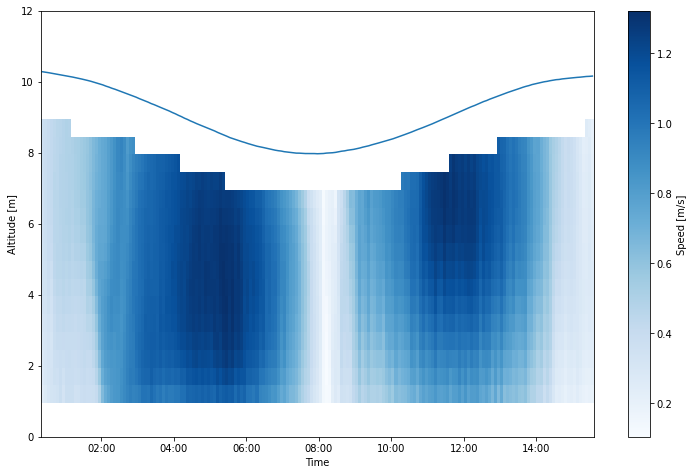

In [19]:
%matplotlib inline 
from matplotlib import pyplot as plt
import matplotlib.dates as dt

ax = plt.figure(figsize=(12,8)).add_axes([.14, .14, .8, .74])
# Plot flow speed
t =  dlfn.time.dt642date(ds_avg.time)
plt.pcolormesh(t, ds_avg.range, ds_avg['U_mag'], cmap='Blues', shading='nearest')
# Plot the water surface
ax.plot(t, ds_avg.depth)

# Set up time on x-axis
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(dt.DateFormatter('%H:%M'))

ax.set_ylabel('Altitude [m]')
ax.set_ylim([0, 12])
plt.colorbar(label='Speed [m/s]')

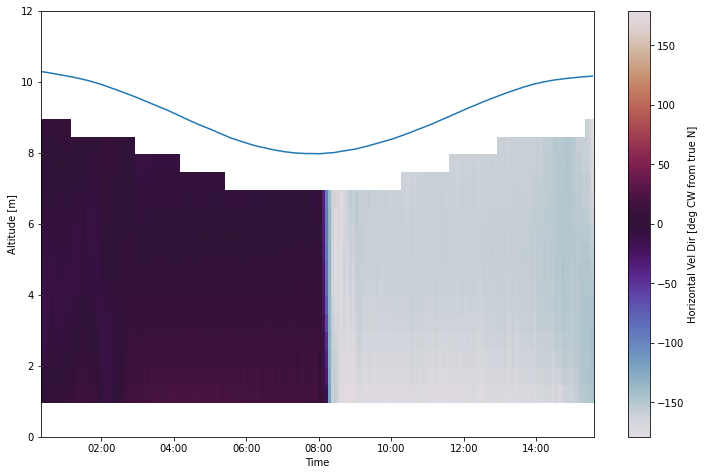

In [20]:
ax = plt.figure(figsize=(12,8)).add_axes([.14, .14, .8, .74])
# Plot flow direction
plt.pcolormesh(t, ds_avg.range, ds_avg['U_dir'], cmap='twilight', shading='nearest')
# Plot the water surface
ax.plot(t, ds_avg.depth)

# set up time on x-axis
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(dt.DateFormatter('%H:%M'))

ax.set_ylabel('Altitude [m]')
ax.set_ylim([0, 12]);
plt.colorbar(label='Horizontal Vel Dir [deg CW from true N]');

## Saving and Loading DOLfYN datasets
Datasets can be saved and reloaded using the `save` and `load` functions. Xarray is saved natively in netCDF format, hence the ".nc" extension.

Note: DOLfYN datasets cannot be saved using xarray's native `ds.to_netcdf`; however, DOLfYN datasets can be opened using `xarray.open_dataset`.

In [21]:
# Uncomment these lines to save and load to your current working directory
#dlfn.save(ds, 'your_data.nc')
#ds_saved = dlfn.load('your_data.nc')